In [1]:
#from ivo

In [2]:
import sys
sys.path.append("/Users/fponce/Documents/vdesert/vdesert_funcs/") 
import import_funcs.vdesert_functions as ff

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import numpy as np
import os
fly, cellType, trace = 'test_0', 'wildType', 'MT'

flyAngle1 = [ -79.05965007,-77.54512746,-77.88935515,-78.15799086,-79.03764785
,-81.84263245,-83.06032492,-83.99092419,-84.41301479,-84.10632104
,-84.2855313, -83.63170201,-82.61478716,-82.22336273,-82.0651695
,-81.32179054,-79.89708624,-79.4220451, -78.08954027,-77.77219797
,-77.29645548,-75.90861756,-74.5633274, -74.67322384,-75.09318523
,-75.15096201,-75.54354755,-76.04768557,-77.34643669,-77.72436575
,-78.61311171,-80.76524567,-82.53386166,-85.81721157,-87.23834343
,-88.59971456,-88.51861113,-88.85627405,-89.19976518,-89.06875655
,-88.22148049,-87.91723752,-86.2943797, -84.29405304,-83.10491072
,-81.57666435,-80.66907063,-78.06055998,-75.77409341,-75.68085589
,-75.27704838,-75.64086724,-75.42004507,-74.31779176,-74.07050949
,-73.97062303,-73.6350036, -73.97898181,-72.69053635,-72.40015877
,-73.38504323,-73.85508043,-74.55334964,-75.58849238,-76.67213771
,-78.63422527,-80.96270283,-83.19538697,-84.34721664,-85.66544736
,-87.05051462,-86.93643284,-86.72724267,-86.33582403,-86.82133147
,-87.44429562,-88.87793786,-91.11497682,-93.77225958,-95.18114545
,-96.83054144,-97.84568528,-99.13972921,-98.80606839,-99.50666464
,-99.24229169, -100.09810996, -102.8082363,-104.69007083, -104.71944895
, -104.9014601,-105.782719, -106.85710722, -107.29214423, -108.77644168
, -109.99449493, -111.53199177, -112.85620763, -114.2223109,-115.20397063]

flyAngle = np.rad2deg(np.unwrap(np.deg2rad(flyAngle1), discont = np.pi))



In [4]:
sFigPath = '/Users/fponce/Documents/vdesert/temp1/'

fVec, fs, headingVeloThresh, headingVeloCeil, magThresh, magCeil = \
np.zeros_like(flyAngle),30., 20., 240., 10., 140.# default values
#64.,60.,2500.(ceil),6.,180. #the 10 could be 10

In [12]:
## Local functions (inside this function, so they don't need to be separately defined)
from scipy.signal import butter,filtfilt

def butter_lowpass(th_order=4, highcut=260, fs=32.):
    
    nyq = 0.5 * fs
    high = highcut / nyq
    return butter(th_order, high, btype='low')

def filtTrace(inArr, fs):
    
    th_order, highcut = 4, 6.#highcut is 6 based of Maimons paper, could be up to 9 
    d, c = butter_lowpass(th_order, highcut, fs)
    return filtfilt(d, c, inArr)

def calcMag(idx, headingVelo, flyAngleFilt): 
    # calculate difference in heading angle between nearest local extremes (of opposite sign)
    
    k=0
    chkMore=True
    refSign=np.sign(headingVelo[idx])
    while chkMore:
        k += 1
        compSign=np.sign(headingVelo[idx-k])
        if refSign != compSign: # if not equal
            onIdx=idx-k+1
            chkMore=False
    k=0
    chkMore=True
    while chkMore:
        k += 1
        compSign=np.sign(headingVelo[idx+k])
        if refSign != compSign:
            offIdx=idx+k
            chkMore=False
    # integrate: BR (behavioral response) = dWSA(offIdx)-dWSA(onIdx)
    return flyAngleFilt[offIdx] - flyAngleFilt[onIdx], onIdx, offIdx 


def sacOnly(inVec, fVec):
    fVecSqz = np.squeeze(fVec)
    outVec = np.array( np.sum([inVec, fVecSqz], axis=0) ).transpose()
    outVec[outVec == 0] = np.nan
    return outVec


def pltSacs(flyAngle, headingVelo, SVMxThr, SVMnThr, flyAngleFilt, SSctnMx, SSctnMn):
    
    #from mpl_functions import adjust_spines
    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    
    timeCol = np.arange(len(flyAngle))/fs
    sttT, endT = timeCol[0], timeCol[-1] # substitute if desired
    figure_padding = 0.25
    subplot_padding = 0.04
    kleur2 = 'black'
    lijnbreedte = .5
    WoverH = 2. # figure ratio: W/H

    headingVeloRange = 12 * headingVeloThresh

    yLimMin, yLimMax = np.nanmin(flyAngle[10:-10]), np.nanmax(flyAngle[10:-10])
#        yRange = yLimMax - yLimMin
#        yRangeAdd  = 2*magCeil
    yLimMinPlt = yLimMin#-yRangeAdd

#        yCtrPlt = yLimMin-magCeil
#        magCeilMinPlt = yCtrPlt+magCeil
#        magCeilMinPlt = yCtrPlt-magCeil
#        magTreshPlt = magCeil

    figH = 2.
    figW = WoverH * figH
    fig = plt.figure(figsize=(figW,figH))
    fig.set_facecolor('w')

    aspect_ratio = (4+subplot_padding)/(12.+subplot_padding)
    gs0 = gridspec.GridSpec(2, 1, height_ratios=[1,1.67]) #width_ratios=[20,1,1,1], 
    gs0.update(left=figure_padding*aspect_ratio, right=1-figure_padding*aspect_ratio, 
               wspace=subplot_padding, hspace=subplot_padding, 
               top=1-figure_padding+subplot_padding, bottom=figure_padding-subplot_padding)
    ax0 = plt.subplot(gs0[0, 0]) # headingVelo       
    ax2 = plt.subplot(gs0[1, 0]) # LmR and sacs  

    ax0.axhspan(0, 0, alpha=.5, color='k', zorder=0, linewidth=.5*lijnbreedte)
    ax0.axhspan(headingVeloThresh, headingVeloThresh, linestyle='--', 
                alpha=.5, color='k', zorder=0, linewidth=.5*lijnbreedte)
    ax0.axhspan(-headingVeloThresh, -headingVeloThresh, linestyle='--', 
                alpha=.5, color='k', zorder=0, linewidth=.5*lijnbreedte)
    ax0.axhspan(headingVeloCeil, headingVeloCeil, linestyle=':', 
                alpha=.5, color='k', zorder=0, linewidth=.5*lijnbreedte)
    ax0.axhspan(-headingVeloCeil, -headingVeloCeil, linestyle=':', 
                alpha=.5, color='k', zorder=0, linewidth=.5*lijnbreedte)

#        ax2.axhspan(yCtrPlt, yCtrPlt,  alpha=.5, color='k', zorder=0, linewidth=.5*lijnbreedte)
#        ax2.axhspan(yCtrPlt+magThresh, yCtrPlt+magThresh, linestyle='--', 
#alpha=.5, color='k', zorder=0, linewidth=.5*lijnbreedte)
#        ax2.axhspan(yCtrPlt-magThresh, yCtrPlt-magThresh, linestyle='--', 
#alpha=.5, color='k', zorder=0, linewidth=.5*lijnbreedte)
#        ax2.axhspan(yCtrPlt+magCeil,   yCtrPlt+magCeil, linestyle=':', 
#alpha=.5, color='k', zorder=0, linewidth=.5*lijnbreedte)
#        ax2.axhspan(yCtrPlt-magCeil,   yCtrPlt-magCeil, linestyle=':', 
#alpha=.5, color='k', zorder=0, linewidth=.5*lijnbreedte)

    ax0.plot(timeCol, headingVelo, color='k', zorder=2, linewidth=lijnbreedte)
    ax0.plot(timeCol, SVMxThr, linestyle='None', marker='.', color='b', markersize=2, zorder=20)
    ax0.plot(timeCol, SVMnThr, linestyle='None', marker='.', color='r', markersize=2, zorder=20)  

    ax2.plot(timeCol, flyAngle, color='g', zorder=4, linewidth=lijnbreedte*.5)
    ax2.plot(timeCol, flyAngleFilt, color='k', zorder=2, linewidth=lijnbreedte)
    ax2.plot(timeCol, SSctnMx, color='b', zorder=19, linewidth=lijnbreedte)
    ax2.plot(timeCol, SSctnMn, color='r', zorder=19, linewidth=lijnbreedte)
#        ax2.plot(timeCol, yCtrPlt+SMagMx, linestyle='None', marker='.', color='b', markersize=2, zorder=20)
#        ax2.plot(timeCol, yCtrPlt+SMagMn, linestyle='None', marker='.', color='r', markersize=2, zorder=20)

    ax0.set_ylabel('ang. vel. ($^\circ$/s)', labelpad=0, fontname='Arial')
    ax0.yaxis.set_label_position('right')

    ax0.set_xlim((sttT, endT))
    ax0.set_ylim((-headingVeloRange,headingVeloRange)) #data
    #adjust_spines(ax0,'right', yticks=[-headingVeloCeil, 0, headingVeloCeil], linewidth=.6, spineColor=kleur2)
    ff.adjust_spines(ax0,'left', yticks=[0, headingVeloRange], linewidth=.6, spineColor=kleur2)
    ax2.set_ylabel('angle ($^\circ$)', labelpad=0, fontname='Arial')

    ax2.set_xlim((sttT, endT))
    ax2.set_ylim((yLimMinPlt,yLimMax)) #data
    #+10,+2 depends on trial length!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    ff.adjust_spines(ax2,['left', 'bottom'], xticks=[sttT, sttT+2], yticks=[yLimMin, yLimMax], 
                  linewidth=.6, spineColor=kleur2)
#        ax2.text(sttT+2, yLimMinPlt-25, '10 s', color=kleur2, fontname='Arial') 
    ax2.spines['bottom'].set_linewidth(1.) #axis

    if not os.path.exists(sFigPath):
        os.makedirs(sFigPath)
    print ('figs can be found here: ' + sFigPath)
    ax2.set_xticks([ ]) # TOGGLE TO hide TIME TICKS
    savePlotName = sFigPath + '_' + fly + '.png'
    fig.savefig(savePlotName , bbox_inches='tight', dpi = 1200)
#        print 'saved to check Sac_ID results: ' + savePlotName
#        print ' '
    plt.close

### end of local functions

In [20]:
def findSacs(flyAngle,  *args):


# Finds local min-/maxima that are within threshold/ceiling bounds of wing steering velocity (headingVelo)
# Subsequently, integrates the unidirectional headingVelo sections surrounding local extremes, 
#and retain only those saccades that supersede magnitude thresholds.
# Usage: 
# $ import Sac_ID as sid
# $ SAmx, SAmn, SVmx, SVmn = sid.findSacs(flyAngle)
# IN:
# flyAngle: the Fly Angle
# OUT:
# SAmx, SAmn, SVmx, SVmn: np.nan vectors with saccade Angles or saccade Velocities in positive 
#and negative directions, respectively
    
# Extra IN (if you don't want to use defaults):
# All you need to call this function is above this line. rest is extra.
# fVec: A np.zeros vector with NaN entries where the fly is not flying
# fs: the sampling frequency
# headingVeloThresh, headingVeloCeil, magThresh, magCeil: thresholds and magnitudes

              
    import os
    import numpy as np
    from scipy.signal import butter, filtfilt
    
    fly, cellType, trace = 'test_0', 'wildType', 'MT'
    

    # Default saccade identifier parameters
    plotQ = True
    deffVec, deffs, defheadingVeloThresh, defheadingVeloCeil, defmagThresh, defmagCeil = \
    np.zeros_like(flyAngle),30., 20., 240., 10., 140.# default values
    ## check for arguments
    varargin = args
    nargin = 1 + len(varargin)
    if nargin == 1:
        fVec, fs, headingVeloThresh, headingVeloCeil, magThresh, magCeil = \
        deffVec, deffs, defheadingVeloThresh, defheadingVeloCeil, defmagThresh, defmagCeil
    elif nargin == 2:
        fs, headingVeloThresh, headingVeloCeil, magThresh, magCeil = \
        deffs, defheadingVeloThresh, defheadingVeloCeil, defmagThresh, defmagCeil
        fVec = varargin[0]
    elif nargin == 3:
        headingVeloThresh, headingVeloCeil, magThresh, magCeil = \
        defheadingVeloThresh, defheadingVeloCeil, defmagThresh, defmagCeil
        fVec, fs = varargin[0], varargin[1]
    elif nargin == 4:
        headingVeloCeil, magThresh, magCeil = defheadingVeloCeil, defmagThresh, defmagCeil
        fVec, fs, headingVeloThresh = varargin[0], varargin[1], varargin[2]
    elif nargin == 5:
        magThresh, magCeil = defmagThresh, defmagCeil
        fVec, fs, headingVeloThresh, headingVeloCeil = varargin[0], varargin[1], varargin[2], varargin[3]
    elif nargin == 6:
        magCeil = defmagCeil
        fVec, fs, headingVeloThresh, headingVeloCeil, magThresh = varargin[0], 
        varargin[1], varargin[2], varargin[3], varargin[4]
    elif nargin == 7:
        fVec, fs, headingVeloThresh, headingVeloCeil, magThresh, magCeil = varargin[0], 
        varargin[1], varargin[2], varargin[3], varargin[4], varargin[5]
    else:
        print ('could not assign all parameters')

    ## Low-pass filter the incoming angle vector
    flyAngleFilt= filtTrace(flyAngle, fs)
    #flyAngleFilt = flyAngle
    ## d/dt the filtered angle vector
    headingVelo=np.zeros_like(flyAngleFilt)
    for k in range(len(flyAngleFilt)-1):
        headingVelo[k]=(flyAngleFilt[k+1]-flyAngleFilt[k])*fs
        
    # In words: find local extremes that exceed headingVelo threshold during flight
    # subsequently, integrate the unidirectional headingVelo sections surrounding local extremes.        
    
    ## Place holders
    headingVeloMxThr,   headingVeloMnThr= np.zeros_like(headingVelo), np.zeros_like(headingVelo) 
    SheadingVeloMx,     SheadingVeloMn  = np.zeros_like(headingVelo), np.zeros_like(headingVelo)
    lcMxMagTemp,    lcMnMagTemp = np.zeros_like(headingVelo), np.zeros_like(headingVelo)
    lcMxMag,        lcMnMag     = np.zeros_like(headingVelo), np.zeros_like(headingVelo) 
    sacMx,          sacMn       = np.zeros_like(headingVelo), np.zeros_like(headingVelo)
    lcMnonIdx,      lcMnoffIdx  = np.zeros_like(headingVelo), np.zeros_like(headingVelo)
    lcMxonIdx,      lcMxoffIdx  = np.zeros_like(headingVelo), np.zeros_like(headingVelo)
    lcMxdeltaIdx,   lcMndeltaIdx= np.zeros_like(headingVelo), np.zeros_like(headingVelo)
    SacAngMx,       SacAngMn    = np.zeros_like(headingVelo), np.zeros_like(headingVelo)
    SacIdxMx,       SacIdxMn    = np.zeros_like(headingVelo), np.zeros_like(headingVelo)
        
    ## Find local extremes in the rate, that exceed the saccade velocity threshold 
    #0.5 not trivially chosen
    reboundIds = int(np.floor(.5*fs)) # .5 s refractory period!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    for idx in range (reboundIds,len(headingVelo)-reboundIds):
        if headingVelo[idx]>=headingVelo[idx-1] and headingVelo[idx]>=headingVelo[idx+1] and \
        headingVelo[idx]>headingVeloThresh and headingVelo[idx]<headingVeloCeil:
            headingVeloMxThr[idx] = headingVelo[idx]
        elif headingVelo[idx]<=headingVelo[idx-1] and headingVelo[idx]<=headingVelo[idx+1] and \
        headingVelo[idx]<-headingVeloThresh and headingVelo[idx]>-headingVeloCeil:
            headingVeloMnThr[idx] = headingVelo[idx]
    
    ## Retain extremes that are less than magnitude limit (velocity dependent) 
    #(no longer: also exceed the saccade magnitude threshold)
    # Integrate unidirectional headingVelo sections surrounding local extremes to obtain saccade magnitude
    for idx in range (int(1.4*reboundIds),len(headingVelo)-int(1.4*reboundIds)):
        if abs(headingVeloMxThr[idx])>0: # for every local max
            lcSteerMag, onIdx, offIdx = calcMag(idx, headingVelo, flyAngleFilt)
            if lcSteerMag < magCeil:
                lcMxMagTemp[idx] = lcSteerMag 
                lcMxonIdx[idx] = onIdx
                lcMxoffIdx[idx] = offIdx
                lcMxdeltaIdx[idx] = offIdx-idx
        if abs(headingVeloMnThr[idx])>0: # for every local minimum
            lcSteerMag, onIdx, offIdx = calcMag(idx, headingVelo, flyAngleFilt)
            if lcSteerMag > -magCeil:
                lcMnMagTemp[idx] = lcSteerMag
                lcMnonIdx[idx] = onIdx
                lcMnoffIdx[idx] = offIdx
                lcMndeltaIdx[idx] = offIdx-idx
    
    ## Obtain saccades, retained extremes that are not 'rebounds' (stable pre-onset activity for edgeSec/4).
    for idx in range (reboundIds,len(headingVelo)-reboundIds):
        if lcMxMagTemp[idx]>0: # for every local maximum
            if abs(np.mean(lcMnMagTemp[idx-reboundIds:idx]))<magThresh/reboundIds and \
            ~np.isnan(fVec[idx-reboundIds:idx+reboundIds]).any(axis=0): 
                SheadingVeloMx[idx] = headingVelo[idx]
                lcMxMag[idx] = lcMxMagTemp[idx]
                sacMx[int(lcMxonIdx[idx]):int(lcMxoffIdx[idx])] = flyAngleFilt \
                [int(lcMxonIdx[idx]):int(lcMxoffIdx[idx])]
                sacPeakIdx = int(idx+lcMxdeltaIdx[idx])
                SacAngMx[sacPeakIdx] = flyAngleFilt[sacPeakIdx] # such that saccades can be indicated at peaks 
                SacIdxMx[idx] = sacPeakIdx # indices of saccades, to allow cropping of saccades
        elif lcMnMagTemp[idx]<0: # for every local minimum
            if abs(np.mean(lcMxMagTemp[idx-reboundIds:idx]))<magThresh/reboundIds and \
            ~np.isnan(fVec[idx-reboundIds:idx+reboundIds]).any(axis=0): 
                SheadingVeloMn[idx] = headingVelo[idx]
                lcMnMag[idx] = lcMnMagTemp[idx]
                sacMn[int(lcMnonIdx[idx]):int(lcMnoffIdx[idx])] = flyAngleFilt \
                [int(lcMnonIdx[idx]):int(lcMnoffIdx[idx])]
                sacPeakIdx = int(idx+lcMndeltaIdx[idx])
                SacAngMn[sacPeakIdx] = flyAngleFilt[sacPeakIdx] # such that saccades can be indicated at peaks 
                SacIdxMn[idx] = sacPeakIdx # indices of saccades, to allow cropping of saccades
    ## only when fly is flying, set all other indices to nan    
    SVMxThr, SVMnThr = sacOnly(headingVeloMxThr, fVec), sacOnly(headingVeloMnThr, fVec) # diagnostic

    # SMagMx, SMagMn   = sacOnly(lcMxMag, fVec), sacOnly(lcMnMag, fVec) # diagnostic
    SSctnMx, SSctnMn = sacOnly(sacMx, fVec), sacOnly(sacMn, fVec)
    
    ## plot to verify
    if plotQ:
        pltSacs(flyAngle, headingVelo, SVMxThr, SVMnThr, flyAngleFilt, SSctnMx, SSctnMn)

    SAmx, SAmn       = sacOnly(SacAngMx, fVec), sacOnly(SacAngMn, fVec)
    SVmx, SVmn       = sacOnly(SheadingVeloMx, fVec), sacOnly(SheadingVeloMn, fVec)
    SIdxmx, SIdxmn   = sacOnly(SacIdxMx, fVec), sacOnly(SacIdxMn, fVec)
    #return SAmx, SAmn, SVmx, SVmn, SSctnMx, SSctnMn, SIdxmx, SIdxmn
    return SAmx, SAmn, SVmx, SVmn, headingVelo

In [21]:
#def classSacs(SacIdxVec, LIds, fs):
    #    import numpy as np
    #    # Separate expansion-associated saccades (L) from spontaneous saccades (S, the remainder)
    #    # from CB paper: 
    #    # "classified as loom-elicited, 
    #    # when the peak L-R velocity occurred within 0.5 s of the mean response
    #    # peak relative to the end of the looming stimulus, 
    #    # or classified as spontaneous"
    #    # LPkRespIdx = index where peak is expected (the mean response time)
    #    stimPeakIds = 1.2*fs
    #    LPkRespIds = LIds + stimPeakIds # behavioral response peaks at 1.2 s after stimulus onset (.2 s after max expansion reached)
    #    nanVec, SacIdxVecLm, SacIdxVecSpnt =  np.zeros_like(SacIdxVec)*np.nan, np.zeros_like(SacIdxVec)*np.nan, SacIdxVec
    #    QrtrSecFrames= .5*fs        
    #    for LmNum, LmIdx in enumerate(LPkRespIds): # for every (loom) stimulus peak response index
    #        stimRangeFr, stimRangeTo  = int(LmIdx-QrtrSecFrames), int(LmIdx+QrtrSecFrames)
    #        SacIdxVecLm[stimRangeFr:stimRangeTo] = SacIdxVec[stimRangeFr:stimRangeTo] # simply copy the SacIdxVec for the stimulus windows
    #    SacIdxVecSpnt[~np.isnan(SacIdxVecLm)] = nanVec[~np.isnan(SacIdxVecLm)] # when expansion-associated saccades are present, classify as not spontaneous
    #    return SacIdxVecLm, SacIdxVecSpnt

In [22]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

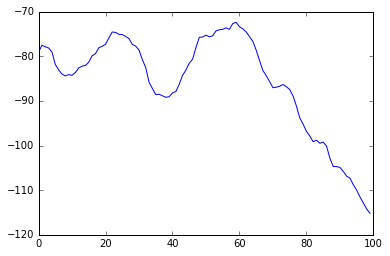

In [23]:
plt.plot(flyAngle)

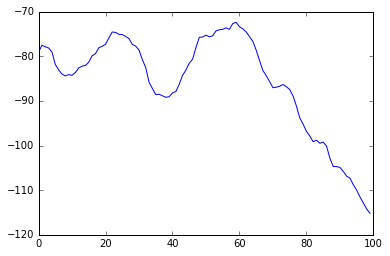

In [24]:
plt.plot(flyAngle1)

figs can be found here: /Users/fponce/Documents/vdesert/temp1/


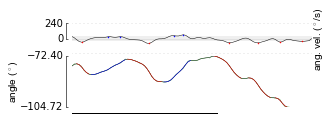

In [25]:
SAmx, SAmn, SVmx, SVmn, v = findSacs(flyAngle)


In [26]:
print(SAmx, SAmn, SVmx, SVmn)


[         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan -74.63564761          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
 -75.37905031          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          

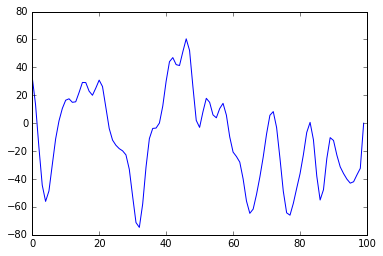

In [27]:
plt.plot(v)